### Imports

In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import random_split
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import json

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

## Classes

In [2]:
#Class: RNN
class RNN(nn.Module):
    #sizes are the number of nodes for respective layers, as ints
    #input_size should be the numbers of variables in input, output_size the number of variables predicted
    #hidden_size should be chosen after experimentation, since we only have one layer it should be more than the number of variables
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1, **kwds):
        super().__init__(**kwds)
        #Number of nodes of the hidden layer (used for init)
        self.hidden_size = hidden_size
        #Weights
        self.i2h = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)
    
    #Input must be torch.Tensor and normalized
    def forward(self, input):
        #h0 = self.initHidden()
        h_list, hn = self.i2h(input)
        output_list = self.h2o(h_list)
        return output_list

In [3]:
#Class : LSTM
class LSTM(nn.Module):
    #sizes are the number of nodes for respective layers, as ints
    #input_size should be the numbers of variables in input, output_size the number of variables predicted
    #hidden_size should be chosen after experimentation, since we only have one layer it should be more than the number of variables
    def __init__(self, input_size, hidden_size, output_size, **kwds):
        super().__init__(**kwds)
        #Number of nodes of the hidden layer (used for init)
        self.hidden_size = hidden_size
        #Weights
        self.i2h = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)

    
    #Input must be torch.Tensor and normalized
    def forward(self, input):
        h_list, (hn,cn) = self.i2h(input)
        output_list = self.h2o(h_list)
        return output_list

## Setup

In [27]:
#Parameters to get several scenari
CSV_FILE = "../../data/synthetic_bph_1/Simulations/simulation1.csv"
CSV_Dtest = "../../data/synthetic_bph_1/Simulations/01_test.csv"
CSV_RES_R = "../../data/synthetic_bph_1/Résultats R script/"
TRAINING_NUMBER = 400
USE_NOISY_DATA = False
USE_MIXED_EFFECT = False
timestep_skip = 1
MODEL = RNN        


In [28]:
#data loading
data = pd.read_csv(CSV_FILE, sep=";", decimal=",")
dtest = pd.read_csv(CSV_Dtest, sep=";", decimal=",")
predictions_R_test = pd.read_csv(CSV_RES_R + "Predictions.csv", sep=",", decimal=".")

In [6]:
x_labels = [
    c for c in data.columns if c.startswith("x") and ((("_" in c) is USE_NOISY_DATA and ('obs' in c) is USE_NOISY_DATA))
]
if 'x8' not in x_labels:
    x_labels.append('x8')
#assert len(x_labels) == 8

y_labels = [
    c
    for c in data.columns
    if c.startswith("y")
    and (("_obs" in c))
    and (("_mixed" in c) is USE_MIXED_EFFECT)
]
assert len(y_labels) == 1

print(x_labels)
print(y_labels)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
['y_fixed_obs']


In [33]:
predictions_R_train = data[['individus','temps', 'pred_mixed', 'pred_fixed', 'pred_naif_fixed']] #don't forget to add , 'pred_naif_mixed'
predictions_R_test = predictions_R_test[['individus','temps', 'pred_mixed_1', 'pred_fixed_1', 'pred_naif_fixed_1']] #don't forget to add , 'pred_naif_mixed _1'

## Preprocessing

In [7]:
data = data[data['temps']%timestep_skip == 0]
data_norm = data.copy()
data_norm = data_norm.dropna()
N_train = random.sample(range(1,501), TRAINING_NUMBER)
N_train.sort()
N_val =  [x for x in range(1,501) if x not in N_train]
data_train = data_norm.loc[data_norm['individus'].isin(N_train)]
data_val = data_norm[~data_norm['individus'].isin(N_train)]

scaler_x = RobustScaler()
data_train.loc[:,x_labels] = scaler_x.fit_transform(data_train[x_labels])
data_val.loc[:,x_labels] = scaler_x.transform(data_val[x_labels ])

scaler_y = RobustScaler()
data_train.loc[:,y_labels] = scaler_y.fit_transform(data_train[y_labels])
data_val.loc[:,y_labels] = scaler_y.transform(data_val[y_labels])

groupby = data_train.groupby('individus')[x_labels].apply(np.array)
input_train = [torch.Tensor(x) for x in groupby]
input_train = torch.stack(input_train)
groupby = data_train.groupby('individus')[y_labels].apply(np.array)
target_train = [torch.Tensor(x) for x in groupby]
target_train = torch.stack(target_train)

groupby = data_val.groupby('individus')[x_labels].apply(np.array)
input_val = [torch.Tensor(x) for x in groupby]
input_val = torch.stack(input_val)
groupby = data_val.groupby('individus')[y_labels].apply(np.array)
target_val = [torch.Tensor(x) for x in groupby]
target_val = torch.stack(target_val)


In [8]:
dtest = dtest[dtest['temps']%timestep_skip == 0]
dtest_norm = dtest.copy()
dtest_norm = dtest_norm.dropna()

scaler_x_test = RobustScaler()
dtest_norm.loc[:,x_labels] = scaler_x.fit_transform(dtest_norm[x_labels])

scaler_y_test = RobustScaler()
dtest_norm.loc[:,y_labels] = scaler_y.fit_transform(dtest_norm[y_labels])

groupby = dtest_norm.groupby('individus')[x_labels].apply(np.array)
input_test = [torch.Tensor(x) for x in groupby]
input_test = torch.stack(input_test)
groupby = dtest_norm.groupby('individus')[y_labels].apply(np.array)
target_test = [torch.Tensor(x) for x in groupby]
target_test = torch.stack(target_test)

## Training

In [9]:
#hyperparamètres
hidden_size = [25]
learning_rate = [ 0.0005]
criterion = torch.nn.MSELoss()
epoch = 20000
eps = 0.0005

In [10]:
#Training with convergence criteria and GridSearch
min_loss = float('inf')
for h in hidden_size:
    for lr in learning_rate:
        model = MODEL(input_size = 8, hidden_size=h, output_size=1, num_layers=2)
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)
        loss_val = [float('inf')]*100
        loss_train = []
        cur_loss_val = 0
        nb_epochs = 0
        while abs(np.max(loss_val[-100:] - np.min(loss_val[-100:] + [cur_loss_val]))) >= eps and nb_epochs < epoch:

            y_val = model(input = input_val)
            cur_loss_val = criterion(y_val, target_val).item()
            loss_val.append(cur_loss_val)

            optimizer.zero_grad()
            y_pred = model(input=input_train)
            loss = criterion(y_pred, target_train)
            loss.backward()
            optimizer.step()

            cur_loss_train = loss.item()
            loss_train.append(cur_loss_train)
            
            nb_epochs += 1
        if cur_loss_val < min_loss:
            min_loss = cur_loss_val
            res = (h, lr)

loss_val = loss_val[101:]
print(h, lr)
print(nb_epochs)

25 0.0005
12697


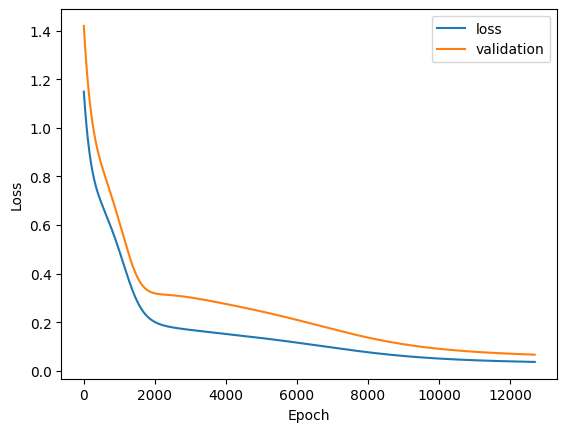

In [11]:
#plot loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.plot(loss_track)
plt.plot(loss_train, label ="loss")
plt.plot(loss_val, label = "validation")
plt.legend()
plt.show()

In [12]:
#unscale data and aggregate training set
multi_index = pd.MultiIndex.from_product([N_train, range(y_pred.shape[1])], names=['individus', 'temps'])
df = pd.DataFrame(index = multi_index, data = y_pred.detach().numpy().flatten(), columns=['y_pred'])
df = df.reset_index()
df = df.set_index(data_train.index)
df.loc[:,'y_pred'] = scaler_y.inverse_transform(df[['y_pred']])
data_train.loc[:,y_labels] = scaler_y.inverse_transform(data_train[y_labels])

multi_index = pd.MultiIndex.from_product([N_val, range(y_val.shape[1])], names=['individus', 'temps'])
df_val = pd.DataFrame(index = multi_index, data = y_val.detach().numpy().flatten(), columns=['y_pred'])
df_val = df_val.reset_index()
df_val = df_val.set_index(data_val.index)
df_val.loc[:,'y_pred'] = scaler_y.inverse_transform(df_val[['y_pred']])
data_val.loc[:,y_labels] = scaler_y.inverse_transform(data_val[y_labels])

df = pd.concat((df,df_val))
data_train = pd.concat((data_train, data_val))

In [13]:
#Results on training
MAE_list_train = []
MSE_list_train = []
for k in range(1,501):
    pred_k = df[(df['temps']>5) & (df['individus'] == k)]['y_pred']
    target_k = data_train[(data_train['temps']>5) & (data_train['individus'] == k)][y_labels[0][:-4]]
    MAE_list_train.append(MAE(pred_k, target_k))
    MSE_list_train.append(MSE(pred_k, target_k))
print("mean MAE on train data: ", np.mean(MAE_list_train))
print("mean MSE on train data: ", np.mean(MSE_list_train))

mean MAE on train data:  0.9314420698334324
mean MSE on train data:  2.4944833441733874


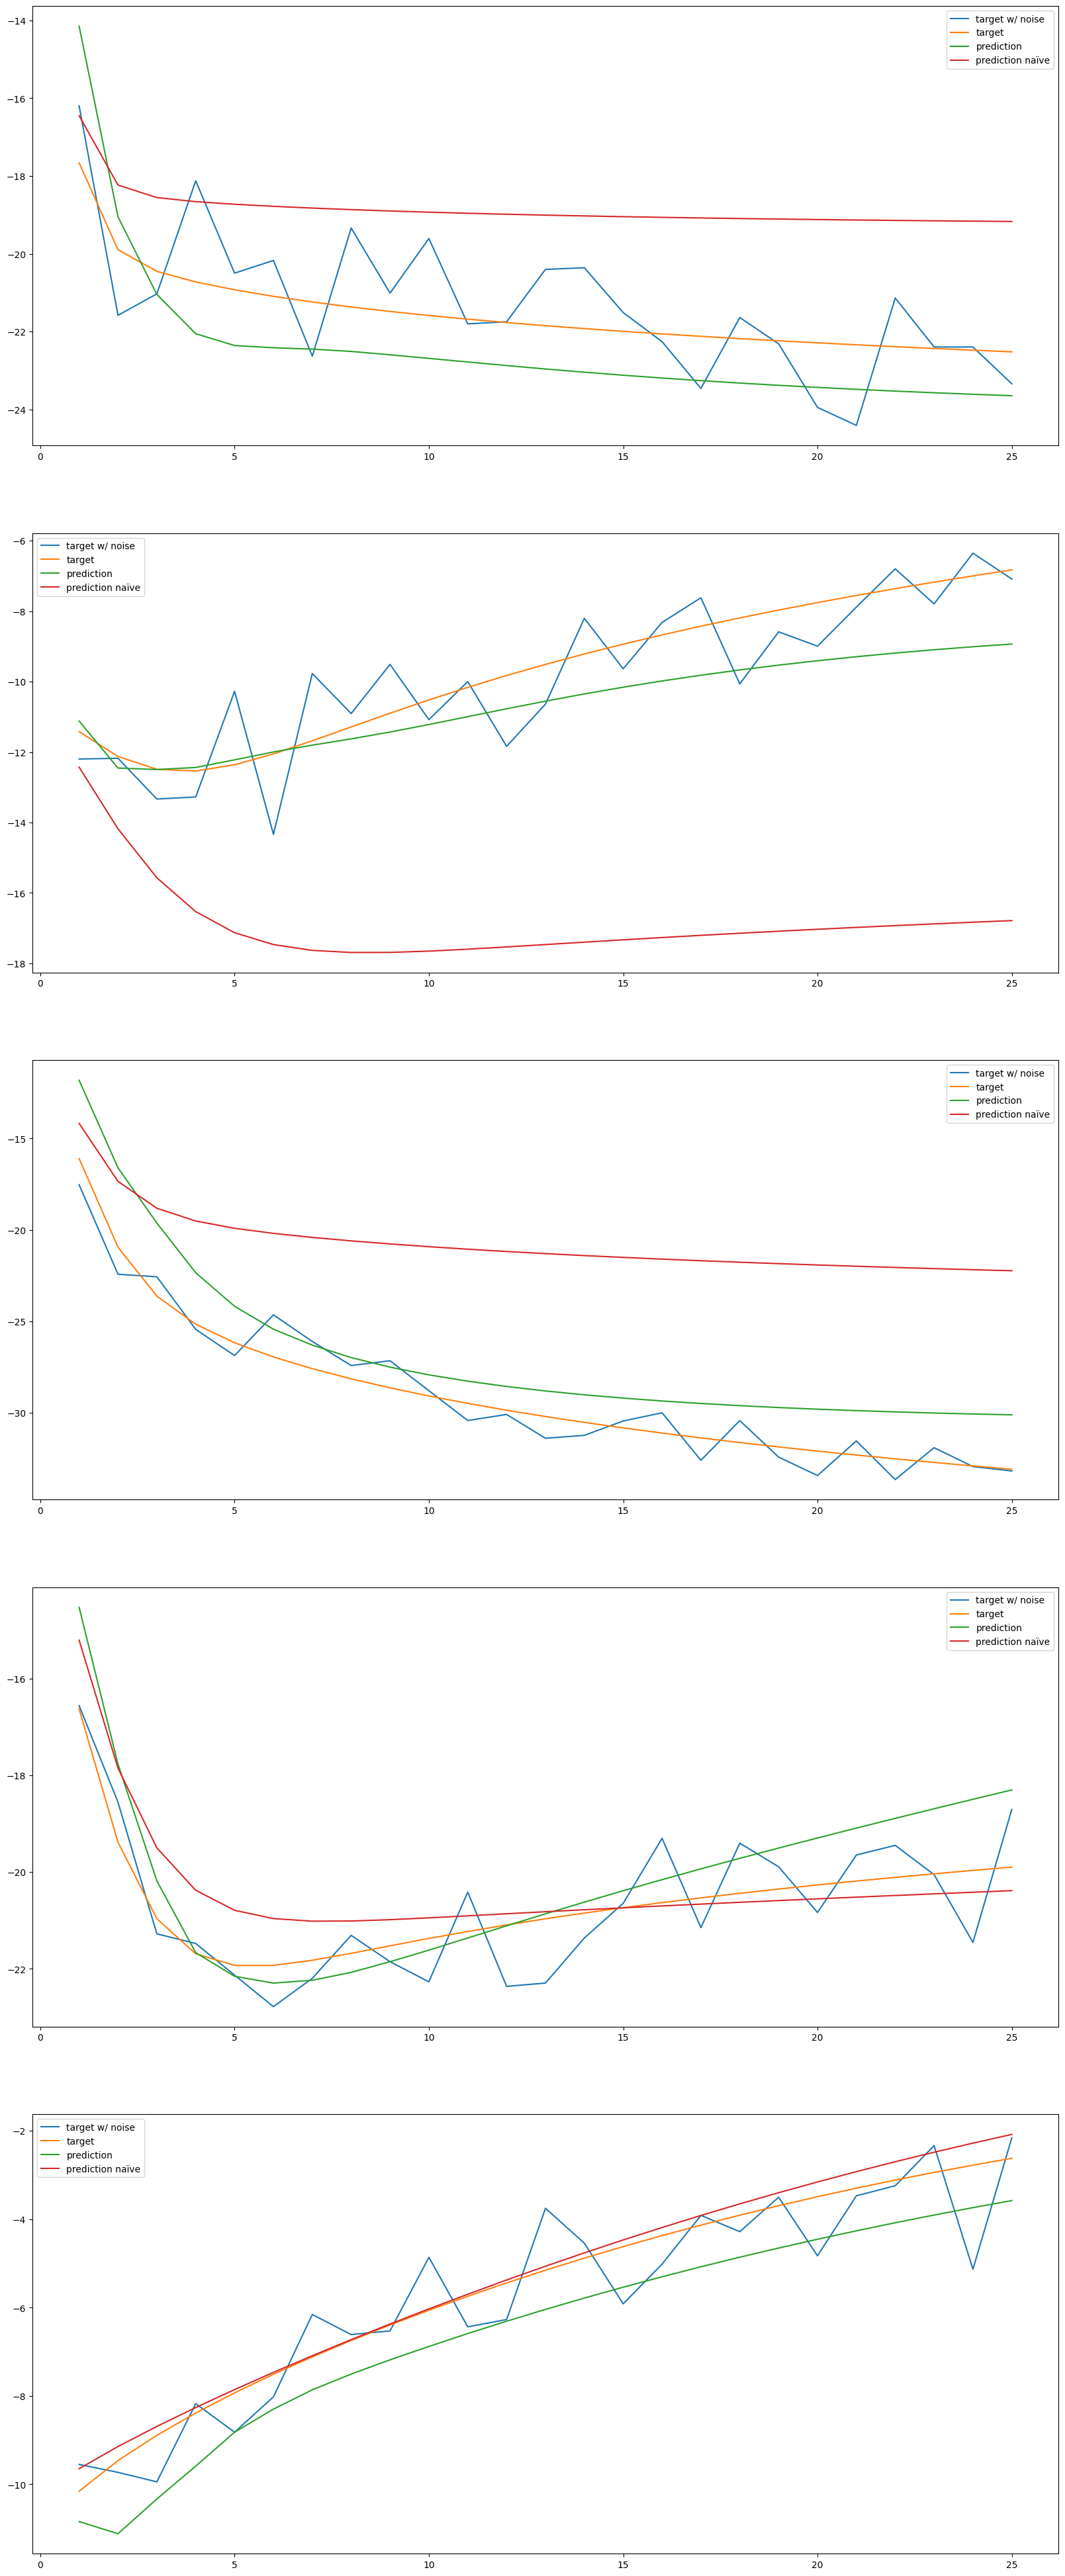

In [43]:
#Plot 4 random curves from training data and worst individual
n = 5
ex = np.random.choice(N_train, n)
fig, axs = plt.subplots(n)
fig.set_figwidth(20)
fig.set_figheight(50)
for k in range(n):
    axs[k].plot(data_train[(data_train['temps']!=0) & (data_train['individus']== ex[k])]['temps'],
                data_train[(data_train['temps']!=0) & (data_train['individus']== ex[k])][y_labels], 
                label= 'target w/ noise')
    axs[k].plot(data_train[(data_train['temps']!=0) & (data_train['individus']== ex[k])]['temps'],
                data_train[(data_train['temps']!=0) & (data_train['individus']== ex[k])][y_labels[0][:-4]], 
                label= 'target')
    axs[k].plot(df[(data_train['temps']!=0) & (df['individus']== ex[k])]['temps'],
                df[(df['temps']!=0) & (df['individus']==ex[k])]['y_pred'], 
                label= 'prediction')
    axs[k].plot(predictions_R_train[(predictions_R_train['temps']!=0) & (predictions_R_train['individus']== ex[k])]['temps'],
                predictions_R_train[(predictions_R_train['temps']!=0) & (predictions_R_train['individus']== ex[k])]['pred_naif_fixed'], 
                label= 'prediction naïve')
    axs[k].legend()
plt.savefig("../../models/ODE-RNN/Résultats/"+ "TRAIN_" + MODEL.__name__ + "_Mixed" + str(USE_MIXED_EFFECT) + "_Timestep" + str("timestep_skip.png"))

## Test

In [15]:
y_test = model(input_test)
multi_index_test = pd.MultiIndex.from_product([range(y_test.shape[0]), range(y_test.shape[1])], names=['individus', 'temps'])
df_test = pd.DataFrame(index = multi_index_test, data = y_test.detach().numpy().flatten(), columns=['y_test'])
df_test = df_test.reset_index()
df_test = df_test.set_index(dtest_norm.index)
df_test['individus']+=1
df_test.loc[:,'y_test'] = scaler_y.inverse_transform(df_test[['y_test']])
dtest_norm.loc[:,y_labels] = scaler_y.inverse_transform(dtest_norm[y_labels])

In [16]:
#MAE on test data
MAE_list_test = []
MSE_list_test = []
for k in range(1,501):
    pred_k = df_test[(df_test['temps']>5) & (df_test['individus'] == k)]['y_test']
    target_k = dtest_norm[(dtest_norm['temps']>5) & (dtest_norm['individus'] == k)][y_labels[0][:-4]]
    MAE_list_test.append(MAE(pred_k,target_k))
    MSE_list_test.append(MSE(pred_k,target_k))
print("mean MAE on test data: ", np.mean(MAE_list_test))
print("mean MSE on test data: ", np.mean(MSE_list_test))

mean MAE on test data:  1.1861087532418364
mean MSE on test data:  4.049957063563464


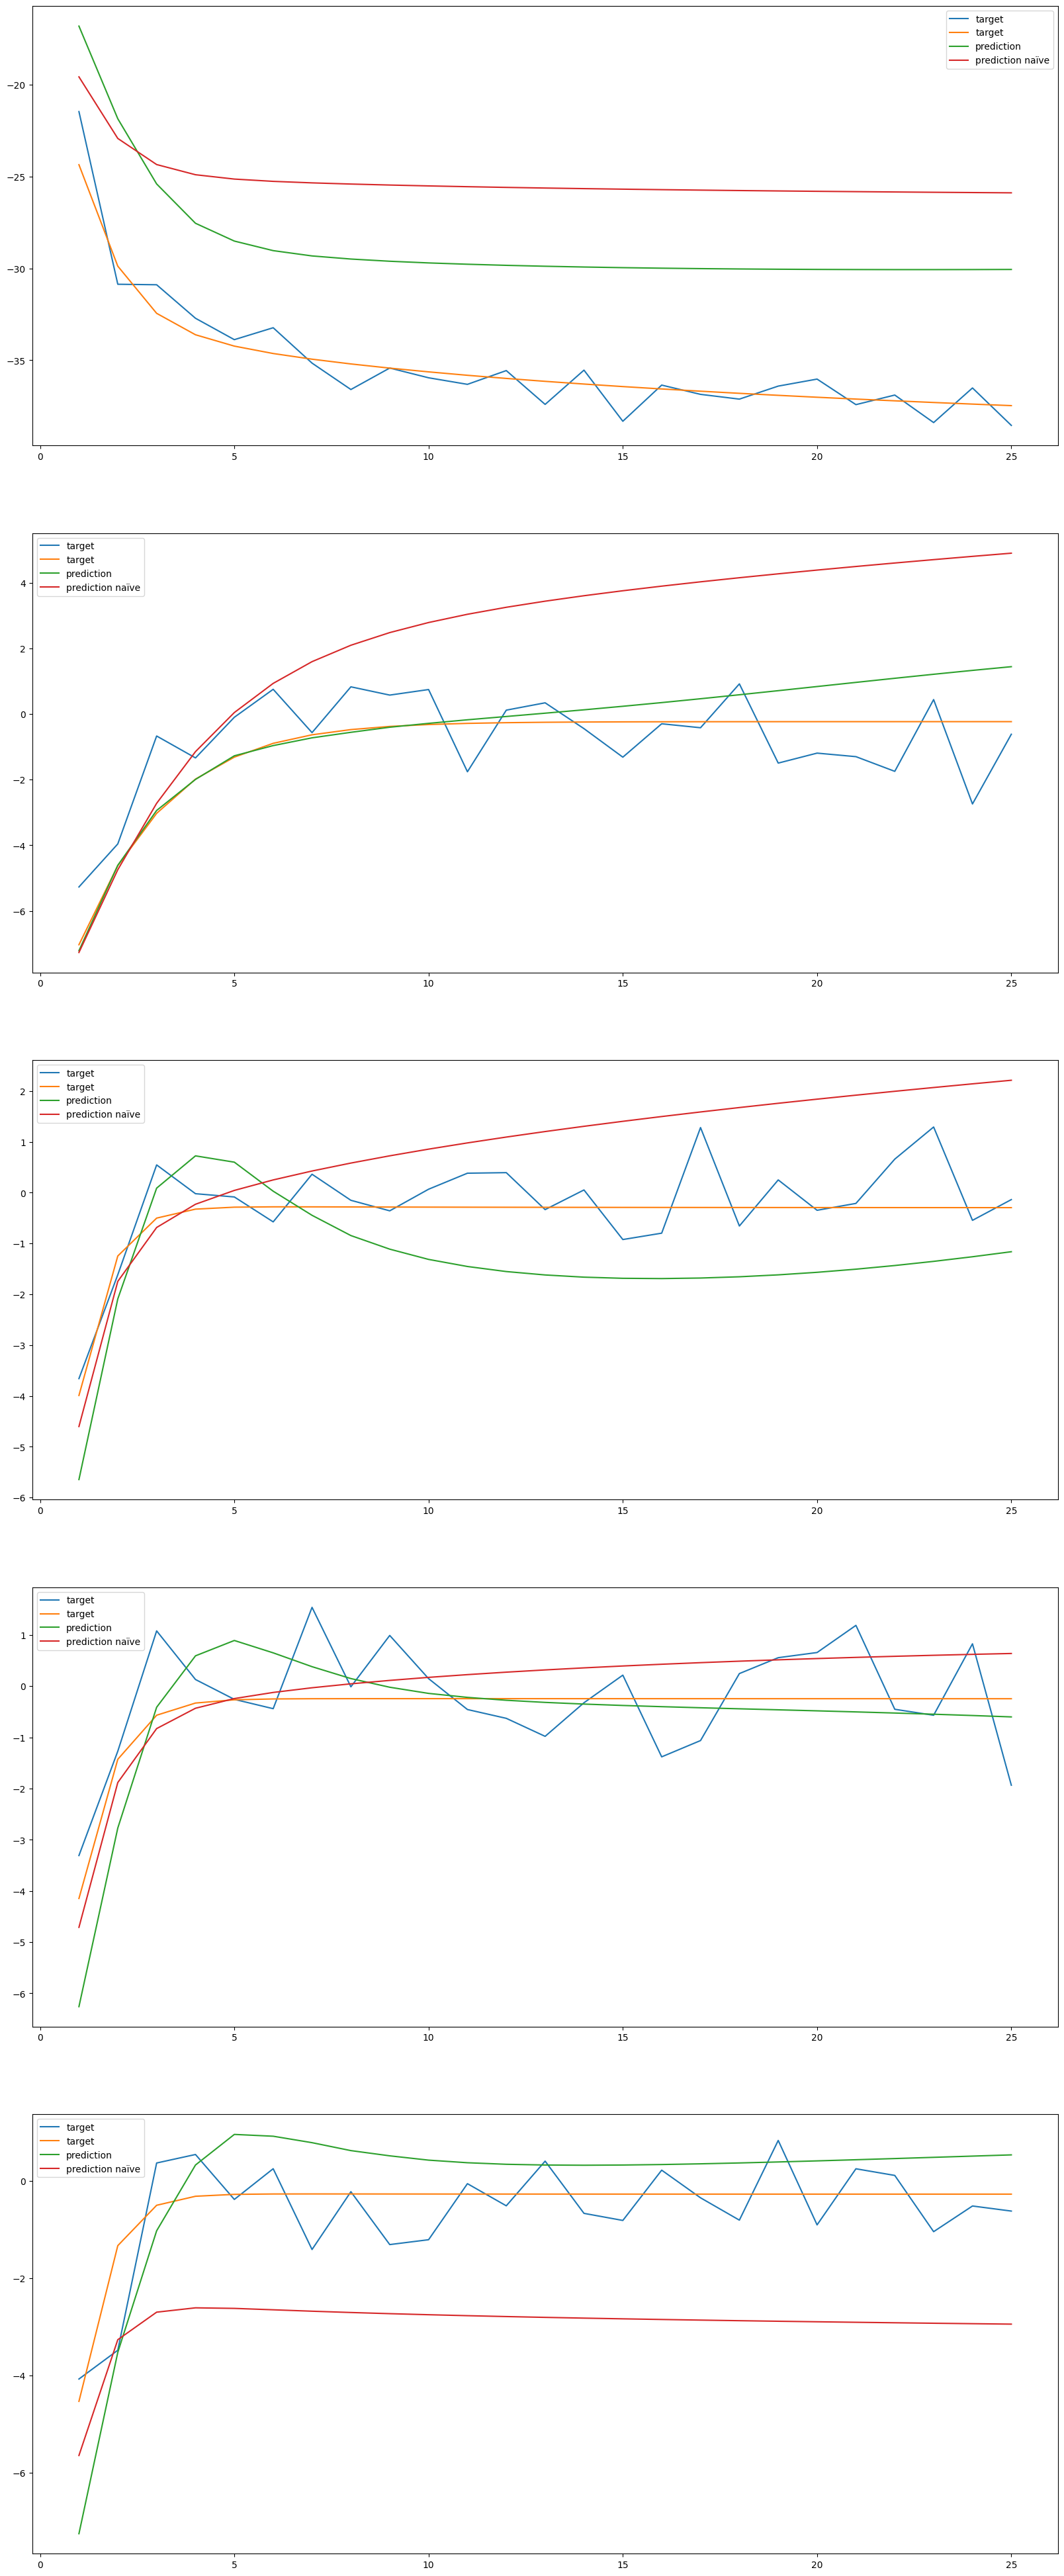

In [46]:
n = 5
ex = randint(1,501, n)
fig, axs = plt.subplots(n)
fig.set_figwidth(20)
fig.set_figheight(50)
for k in range(n):
    axs[k].plot(dtest_norm.loc[(dtest_norm['temps']!=0) & (dtest_norm['individus']==ex[k])]['temps'], 
                dtest_norm.loc[(dtest_norm['temps']!=0) & (dtest_norm['individus']==ex[k])][y_labels], 
                label= 'target')
    axs[k].plot(dtest_norm.loc[(dtest_norm['temps']!=0) & (dtest_norm['individus']==ex[k])]['temps'], 
                dtest_norm.loc[(dtest_norm['temps']!=0) & (dtest_norm['individus']==ex[k])][y_labels[0][:-4]], 
                label= 'target')
    axs[k].plot(df_test.loc[(df_test['temps']!=0) & (df_test['individus']==ex[k])]['temps'],
                df_test.loc[(df_test['temps']!=0) & (df_test['individus']==ex[k])]['y_test'], 
                label= 'prediction')
    axs[k].plot(predictions_R_test[(predictions_R_test['temps']!=0) & (predictions_R_test['individus']== ex[k])]['temps'],
                predictions_R_test[(predictions_R_test['temps']!=0) & (predictions_R_test['individus']== ex[k])]['pred_naif_fixed_1'], 
                label= 'prediction naïve')
    axs[k].legend()
plt.savefig("../../models/ODE-RNN/Résultats/"+ "TEST" + MODEL.__name__ + "_Mixed" + str(USE_MIXED_EFFECT) + "_Timestep" + str("timestep_skip.png"))

## Saving results

In [18]:
results = pd.DataFrame([[USE_MIXED_EFFECT, MODEL.__name__, nb_epochs, np.mean(MAE_list_train), np.mean(MAE_list_test)]], 
                       columns=['Random effect', 'Model', 'nb_epochs', "MAE moyenne sur l'entrainement", "MAE moyenne sur le test"])
print(results)
results = results.to_json(path_or_buf="../../models/ODE-RNN/Résultats/"+ MODEL.__name__ + "_" + "Mixed" + str(USE_MIXED_EFFECT) + "Timestep" + str("timestep_skip.json"))


   Random effect Model  nb_epochs  MAE moyenne sur l'entrainement  \
0          False   RNN      12697                        0.931442   

   MAE moyenne sur le test  
0                 1.186109  


In [19]:
torch.save(model.state_dict(), "../../models/ODE-RNN/Résultats/POIDS_"+ MODEL.__name__ + "_" + "Mixed" + str(USE_MIXED_EFFECT) + "Timestep" + str("timestep_skip"))